# Building a recommender system with embedding

In [1]:
%reload_ext jupyter_black

In [2]:
# Cleaning up the datasets
from typing import Iterable
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, Any
import sklearn.model_selection


def load_min_data(filename: str | Iterable):
    dfs = []
    if isinstance(filename, str):
        filename = [filename]
    for fn in filename:
        df = pd.read_csv(fn)
        # All min-datasets have an index column which has to be dropped:
        dfs.append(df.drop(df.columns[0], axis=1))
    return dfs


def clean_customer_data(df: pd.DataFrame):
    df = df.dropna(subset=["age"])
    df.loc[
        ~df["fashion_news_frequency"].isin(["Regularly", "Monthly"]),
        "fashion_news_frequency",
    ] = "None"
    return df


def clean_article_data(df):
    df.loc[df["index_group_no"] == 26, "index_group_no"] = 0
    return df

In [14]:
## TEMP
# Prøver noe her..
import pandas as pd
import numpy as np
import pickle

print(pd.__version__)
# df = pd.read_csv(
#     "dataset/transactions_train.csv",
#     usecols=["article_id", "customer_id"],
#     dtype={"article_id": str},
# )
# with open("object_storage/transactions.pckl", "wb") as f:
#     pickle.dump(df, f)

1.4.4


Due to the size of the data, it's important to generate negative labels in an efficient way. The function `pandas.DataFrame.sample()` takes almost five seconds for each sample, which is called at least `n_negative` times, we instead transform the dataframe to a NumPy array. Below is a comparison to highlight the importance of working with simpler objects.

In [4]:
def time_pd_vs_np(n_negative, df) -> Tuple[float, float]:
    """Compute time it takes to sample n_negative negative transactions

    Args:
        n_negative (int): Number of negative samples
        df (pd.DataFrame): Dataframe to sample from, requires columns 'customer_id' and 'article_id'

    Returns:
        Tuple[float, float]: Time taken using Pandas objects (first value) and NumPy objects (second value)
    """
    import time

    start_pd = time.time()
    num_written = 0
    tmpStr = "customer_id,article_id\n"
    while num_written < n_negative:
        # Choose random customer and article
        selection = np.array(
            [
                df["customer_id"].sample().values,
                df["article_id"].sample().values,
            ]
        ).flatten()
        if not (
            (df["customer_id"] == selection[0]) & (df["article_id"] == selection[1])
        ).any():
            tmpStr += f"{selection[0]}, {selection[1]}\n"
            num_written += 1
    with open("tmp.csv", "w") as f:
        f.write(tmpStr)
    df_negative = pd.read_csv("tmp.csv")
    os.remove("tmp.csv")
    time_pd = time.time() - start_pd

    # Numpy method
    start_np = time.time()
    df_np = df[["customer_id", "article_id"]].to_numpy()
    neg_np = np.empty((n_negative, df_np.shape[1]), dtype="<U64")
    for i in range(n_negative):
        legit = False
        while not legit:
            sample = [np.random.choice(df_np[:, col]) for col in range(df_np.shape[1])]
            legit = not ((df_np[:, 0] == sample[0]) & (df_np[:, 1] == sample[1])).any()
        neg_np[i, :] = sample
    time_np = time.time() - start_np

    return time_pd, time_np


def plot_negative_sampling(
    start: int,
    stop: int,
    step: int = 1,
    filename: str | None = None,
    persist_data: bool = True,
    cont_from_checkpoint: bool = True,
) -> None:
    """Plot the outputs of `time_pd_vs_np` for different ranges of n_negative

    Args:
        start (int): Range of n_negative (inclusive)
        stop (int): Range of n_negative (exclusive)
        step (int, optional): Step in range of n_negative. Defaults to 1.
        filename (str | None, optional): Plot output file name, if None, does not save file. Defaults to None.
        persist_data (bool, optional): Serialization option to store each iterate's result. Defaults to True.
        cont_from_checkpoint (bool, optional): Reads previous runs and doesn't recompute if done before.
                                                Defaults to True.
    """
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    import pickle

    xax = list(range(start, stop, step))

    if cont_from_checkpoint:
        with open("plotData.pckl", "rb") as f:
            plot_values = pickle.load(f)

        # Add empty list for keys not covered by checkpoint:
        computed = set([x_i for x_i in plot_values.keys()])
        to_add = set(xax) - computed
        for elem in to_add:
            plot_values[elem] = []

        # Skip those already computed
        xax = [x for x in xax if x not in computed]

    else:
        plot_values = {x_i: [] for x_i in xax}

    for n_negative in tqdm(xax):
        time_pd, time_np = time_pd_vs_np(n_negative)
        plot_values[n_negative].extend([time_pd, time_np])

        if persist_data:
            with open("plotData.pckl", "wb") as f:
                pickle.dump(plot_values, f)

    plt.plot(
        plot_values.keys(),
        plot_values.values(),
        label=[
            "pandas.DataFrame.sample implementation",
            "NumPy.random.choice implementation",
        ],
    )
    plt.legend()
    plt.xlabel("Number of negative (generated) samples")
    plt.ylabel("Time [s]")
    plt.title("Comparison between sampling methods time")
    if filename is not None:
        plt.savefig(f"{filename}.pdf")
    plt.show()


# plot_negative_sampling(
#     start=1,
#     stop=50,
#     step=1,
#     filename="Comp_1_to_50",
#     persist_data=True,
#     cont_from_checkpoint=True,
# )

In [5]:
# Data loading
from sklearn.preprocessing import LabelEncoder


class Data_HM(Dataset):
    """This is the general HM Dataset class whose children are train-dataset and validation-dataset
    no

    Args:
        Dataset: Abstract Dataset class from pyTorch
    """

    def __init__(
        self,
        total_cases: int,
        portion_negatives: float,
        df_transactions: pd.DataFrame,
        df_articles: pd.DataFrame,
        df_customers: pd.DataFrame,
        batch_size: int,
        train_portion: float | None = None,
        test_portion: float | None = None,
        transform: Any = None,
        target_transform: Any = None,
    ) -> None:
        super().__init__()
        if train_portion is None:
            if test_portion is None:
                raise ValueError("Both train portion and test portion cannot be None.")
            self.train_portion = 1 - test_portion
        self.batch_size = batch_size
        self.df_id, self.le_cust, self.le_art = self.generate_dataset(
            total_cases, portion_negatives, df_transactions
        )
        self.train_portion = train_portion
        self.train, self.val = self.split_dataset()
        self.transform, self.target_transform = transform, target_transform

    def generate_dataset(
        self, total_cases: int, portion_negatives: float, df_transactions: pd.DataFrame
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Produce DataFrames for positive labels and generated negative samples

        Args:
            total_cases (int): Total number of transactions
            portion_negatives (float): The portion of the `total_cases` that should be negative. Balanced 0/1 when 0.5
            df_transactions (pd.DataFrame): Transactions to pull samples/generate samples from

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: _description_
        """
        assert (
            0 <= portion_negatives <= 1
        ), r"portion negatives must be a float between 0%=0.0 and 100%=1.0!"
        if total_cases is None:
            total_cases = len(df_transactions)
        n_positive = round(total_cases * (1 - portion_negatives))
        n_negative = total_cases - n_positive

        df_positive = df_transactions.sample(n=n_positive).reset_index(drop=True)
        df_positive = df_positive[["customer_id", "article_id"]]
        df_positive["label"] = 1

        # Sampling negative labels:
        #   We select a random combination of `customer_id`, `article_id`, and ensure that this is not a true transaction.
        #   Then we make a 2-column dataframe on same form as `df_positive`

        df_np = df_transactions[["customer_id", "article_id"]].to_numpy()
        neg_np = np.empty((n_negative, df_np.shape[1]), dtype="<U64")
        for i in range(n_negative):
            legit = False
            while not legit:
                sample = [
                    np.random.choice(df_np[:, col]) for col in range(df_np.shape[1])
                ]
                legit = not (
                    (df_np[:, 0] == sample[0]) & (df_np[:, 1] == sample[1])
                ).any()
            neg_np[i, :] = sample
        neg_np = np.column_stack((neg_np, [0] * neg_np.shape[0]))
        df_negative = pd.DataFrame(neg_np, columns=df_positive.columns)
        # Return a shuffled concatenation of the two dataframes
        full_data = (
            pd.concat((df_positive, df_negative)).sample(frac=1).reset_index(drop=True)
        )

        # Make label encodings of the IDs
        le_cust = LabelEncoder()
        le_art = LabelEncoder()
        le_cust.fit(full_data["customer_id"])
        le_art.fit(full_data["article_id"])
        cust_encode = le_cust.transform(full_data["customer_id"])
        art_encode = le_art.transform(full_data["article_id"])
        return (
            pd.DataFrame(
                data={
                    "customer_id": cust_encode,
                    "article_id": art_encode,
                    "label": full_data["label"].astype(np.uint8),
                }
            ),
            le_cust,
            le_art,
        )

    def __len__(self):
        return len(self.df_id.index)

    def __getitem__(self, idx):
        row, label = self.df_id.iloc[idx, :-1].values, self.df_id.iloc[idx, -1]
        label = int(label)  # Stored as str initially
        if self.transform:
            row = self.transform(row)
        if self.target_transform:
            label = self.target_transform(label)
        return row, label

    def split_dataset(self):
        """Split full data to train and validation Subset-objects

        Returns:
            Tuple[Subset, Subset]: Train and validation subsets
        """
        length = len(self)
        train_size = int(length * self.train_portion)
        valid_size = length - train_size
        train, val = torch.utils.data.random_split(self, [train_size, valid_size])
        return train, val

    def get_data_from_subset(self, subset: torch.utils.data.Subset):
        """Not in use currently, but can retrieve data from Subset object directly"""
        return subset.dataset.df_id.iloc[subset.indices]

    def get_DataLoader(self, trainDL: bool = True):
        subset = self.train if trainDL else self.val
        return DataLoader(dataset=subset, batch_size=self.batch_size)

In [6]:
# Embedding model (same model as Mind Data example)


class HM_model(torch.nn.Module):
    def __init__(self, num_customer, num_articles, embedding_size):
        super(HM_model, self).__init__()
        self.customer_embed = torch.nn.Embedding(
            num_embeddings=num_customer, embedding_dim=embedding_size
        )
        self.art_embed = torch.nn.Embedding(
            num_embeddings=num_articles, embedding_dim=embedding_size
        )
        self.customer_bias = torch.nn.Embedding(num_customer, 1)
        self.article_bias = torch.nn.Embedding(num_articles, 1)

    def forward(self, customer_row, article_row):
        customer_embed = self.customer_embed(customer_row)
        art_embed = self.art_embed(article_row)
        # dot_prod_old = torch.sum(torch.mul(customer_embed, art_embed), 1)
        dot_prod = (customer_embed * art_embed).sum(dim=1, keepdim=True)
        # Add bias nodes to model:
        dot_prod = (
            dot_prod + self.customer_bias(customer_row) + self.article_bias(article_row)
        )
        return torch.sigmoid(dot_prod)

In [7]:
from tqdm import tqdm
from datetime import datetime


def train_one_epoch(
    model: HM_model,
    data: Data_HM,
    epoch_num: int,
    optimizer,
    loss,
    lr_scheduler,
    verbose: bool = False,
):
    epoch_loss = 0
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for item in data.get_DataLoader(trainDL=True):
        item = tuple(t.to(device) for t in item)
        row, label = item
        optimizer.zero_grad()
        pred = model(row[:, 0], row[:, 1])
        loss_value = loss(pred.view(-1), torch.FloatTensor(label.tolist()).to(device))
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value
    if verbose:
        print(f"\t| Training loss for epoch {epoch_num+1}: {epoch_loss}")
    return epoch_loss


def train(model, data, params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Uses binary cross entropy at the moment
    loss_metric = torch.nn.BCELoss().to(device)
    optimizer = params.optimizer(
        model.parameters(), lr=params.lr_rate, weight_decay=params.weight_decay
    )
    # Adjust lr once model stops improving using scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    save_loss = params.save_loss
    if save_loss:
        train_losses = []
        valid_losses = []
        # Settings not in use atm but we can get the hyperparams from it:))
        settings = ",".join([str(v) for v in params.__dict__.values()])
    for epoch in tqdm(range(params.epochs)):
        model.train()
        epoch_loss = train_one_epoch(
            model, data, epoch, optimizer, loss_metric, lr_scheduler, params.verbose
        )
        if not epoch % params.validation_frequency:
            # Validate step
            model.eval()
            valid_loss = 0.0
            for item in data.get_DataLoader(trainDL=False):
                item = tuple(t.to(device) for t in item)
                row, label = item
                pred = model(row[:, 0], row[:, 1])
                loss = loss_metric(
                    pred.view(-1), torch.FloatTensor(label.tolist()).to(device)
                )
                valid_loss = loss.item() * row.size(0)

            lr_scheduler.step(valid_loss)  # Update lr scheduler
            if params.verbose:
                print(f"Provisory results for epoch {epoch+1}:")
                print(
                    "Loss for training set",
                    epoch_loss.tolist() / len(data.get_DataLoader(trainDL=True)),
                    sep="\t",
                )
                print(
                    "Loss for validation set",
                    valid_loss / len(data.get_DataLoader(trainDL=False)),
                    sep="\t",
                )
                print("-" * 20)
            if save_loss:
                train_losses.append(
                    epoch_loss.tolist() / len(data.get_DataLoader(trainDL=True))
                )
                valid_losses.append(
                    valid_loss / len(data.get_DataLoader(trainDL=False))
                )
    if save_loss:
        fn_append = save_loss if isinstance(save_loss, str) else ""
        save_dir = os.path.join("results", datetime.today().strftime("%Y.%m.%d.%H.%M"))
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        np.savetxt(
            os.path.join(save_dir, f"losses_{fn_append}.csv"),
            np.transpose([train_losses, valid_losses]),
            delimiter=",",
        )
    return valid_loss / len(data.get_DataLoader(trainDL=False))


import utils.metrics as metric
import importlib

importlib.reload(metric)  # To caputre changes in metrics module


def save_dataset_obj(data: HM_model, dst: str) -> None:
    import pickle, os

    if not os.path.isdir(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    with open(dst, "wb") as f:
        pickle.dump(data, f)


def read_dataset_obj(src: str) -> Any:
    import pickle

    with open(src, "rb") as f:
        data = pickle.load(f)
    return data


import matplotlib.pyplot as plt


def plot_loss_results(
    lossfile, which: str = "all", plot_title: bool = True, save: str | None = None
):
    res = pd.read_csv(lossfile, header=None)
    if which != "validation":
        plt.plot(res[0], label="Training loss")
    if which != "training":
        plt.plot(res[1], label="Validation loss")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss value")
    plt.legend()
    title = "Training and validation" if which == "all" else which.capitalize()
    title += " loss for extended model"
    if plot_title:
        plt.title(title)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [8]:
from dataclasses import dataclass, asdict
from tabnanny import verbose
from typing import Any

from numpy import isin


@dataclass
class Hyperparameters:
    lr_rate: float = 1e-3
    weight_decay: str = 1e-4
    epochs: int = 20
    validation_frequency: int = 1
    optimizer: Any = torch.optim.Adam
    embedding_size: int = 500
    save_loss: bool | str = True
    verbose: bool = False
    dataset_cases: int = 2000
    dataset_portion_negatives: float = 0.9
    dataset_train_portion: float = 0.7
    datset_batch_size: int = 5
    # Add more here...


def main(
    use_min_dataset: bool = False,
    persisted_dataset_path: str | None = None,
    save_model: str | bool = False,
    hyperparams=Hyperparameters(),
    transactions_path: str = "dataset/transactions_train.csv",
):

    # Load data
    if use_min_dataset:
        df_c, df_a, df_t = load_min_data(
            [
                f"dataset_sample/{n}_min.csv"
                for n in ("customer", "articles", "transactions")
            ]
        )
    if persisted_dataset_path is None:
        df_c = pd.read_csv("dataset/customers.csv")
        # Articles IDs all start with 0 which disappears if cast to a number
        df_a = pd.read_csv("dataset/articles.csv", dtype={"article_id": str})
        df_t = pd.read_csv(transactions_path, dtype={"article_id": str})
        df_c = clean_customer_data(df_c)
        df_a = clean_article_data(df_a)

        dataset_params = {
            "total_cases": hyperparams.dataset_cases,
            "portion_negatives": hyperparams.dataset_portion_negatives,
            "df_transactions": df_t,
            "df_articles": df_a,
            "df_customers": df_c,
            "train_portion": hyperparams.dataset_train_portion,
            "batch_size": hyperparams.datset_batch_size,
        }
        data = Data_HM(**dataset_params)
        save_dataset_obj(
            data,
            f"object_storage/dataset-{datetime.today().strftime('%Y.%m.%d.%H.%M')}.pckl",
        )
    else:
        data = read_dataset_obj(persisted_dataset_path)
    n_cust, n_art, _ = data.df_id.nunique()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HM_model(
        num_customer=n_cust,
        num_articles=n_art,
        embedding_size=hyperparams.embedding_size,
    )
    model = model.to(device)

    last_valid_loss = train(model, data, hyperparams)
    if save_model:
        if isinstance(save_model, bool):
            save_model = datetime.today().strftime("%Y.%m.%d.%H.%M") + ".pth"
        torch.save(model.state_dict(), os.path.join("models", save_model))
    return last_valid_loss


# main(persisted_dataset_path="object_storage/HM_data.pckl")

In [24]:
import matplotlib.pyplot as plt
import logging
from typing import Union


def load_kaggle_assets(
    to_download: Union[Iterable[str], None] = None
) -> Iterable[pd.DataFrame]:
    """Downloads data from Kaggle competition, loads to Dataframes and deletes original files. Made due to low disk quota on server

    Args:
        to_download (list[str] | None, optional): List of files to download, if None will download all csv files. Defaults to None.

    Returns:
        list[pd.DataFrame]: Dataframes from downloaded files
    """
    logging.debug("Loading assets from Kaggle to Markov ...")
    from zipfile import ZipFile
    from kaggle.api.kaggle_api_extended import KaggleApi

    api = KaggleApi()
    api.authenticate()
    if to_download is None:
        to_download = ["customers.csv", "transactions_train.csv", "articles.csv"]
    pd_objects = []

    for i, file in enumerate(to_download):
        logging.debug(f"Downlodaing file {file}")
        api.competition_download_file(
            competition="h-and-m-personalized-fashion-recommendations", file_name=file
        )

        zf = ZipFile(f"{file}.zip")
        zf.extractall()
        zf.close()

        # Customers-file does not require dtype specification, the others do
        if i == 0:
            df = pd.read_csv(file)
        else:
            df = pd.read_csv(file, dtype={"article_id": str})
        pd_objects.append(df)
        # Remove files created from download now that it's loaded to memory
        os.remove(file)
        os.remove(f"{file}.zip")
        logging.debug(f"Sucessfully loaded and removed {file}")
    return pd_objects


def _extend_row_data(
    self: Data_HM, customer_rows: Iterable[str], article_rows: Iterable[str]
) -> pd.DataFrame:
    """Adds the given customer/article rows to dataset-object (not in-place)

    Args:
        self (Data_HM): Main dataset object
        customer_rows (Iterable[str]): List of column names of customer info
        article_rows (Iterable[str]): List of column names of article info

    Returns:
        pd.DataFrame: Modified self.df_id with the additional info
    """
    customer_rows = ["customer_id"] + customer_rows
    article_rows = ["article_id"] + article_rows

    # Find original customer and article IDs present in dataset
    df_decoded = self.df_id.copy()
    df_decoded["article_id"] = self.le_art.inverse_transform(df_decoded["article_id"])
    df_decoded["customer_id"] = self.le_cust.inverse_transform(
        df_decoded["customer_id"]
    )
    enc_customers, enc_articles = load_kaggle_assets(
        to_download=["customers.csv", "articles.csv"]
    )
    enc_customers = enc_customers[
        enc_customers["customer_id"].isin(df_decoded["customer_id"])
    ]
    enc_articles = enc_articles[
        enc_articles["article_id"].isin(df_decoded["article_id"])
    ]

    enc_customers["customer_id"] = self.le_cust.transform(enc_customers["customer_id"])
    enc_articles["article_id"] = self.le_art.transform(enc_articles["article_id"])
    df_ext = self.df_id.merge(enc_customers[customer_rows]).merge(
        enc_articles[article_rows]
    )
    # Ensure that last column is the label
    ordered_columns = df_ext.columns[df_ext.columns != "label"].append(
        pd.Index(["label"])
    )
    logging.debug(
        f"df_id has been extended with {', '.join(customer_rows[1:]+article_rows[1:])}"
    )
    return df_ext[ordered_columns]


test = read_dataset_obj("object_storage/dataset-2022.11.26.12.04.pckl")
test.df_id = _extend_row_data(test, ["age"], ["garment_group_no", "index_group_no"])

100%|██████████| 97.9M/97.9M [00:18<00:00, 5.53MB/s]


100%|██████████| 4.26M/4.26M [00:00<00:00, 5.24MB/s]


In [25]:
num_customer, num_articles = test.df_id.nunique().values[:2]
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HM_model(num_customer, num_articles, embedding_size=500).to(device)
model.load_state_dict(
    torch.load("models/2022.11.26.12.28.pth", map_location=torch.device(device))
)

Embedding(46054, 500)


In [48]:
parameter_values = {}
for para in model.named_parameters():
    # print(para[1].detach().numpy())
    parameter_values[para[0]] = para[1].detach().numpy()

In [62]:
print(*[e for e in parameter_values.keys()])

customer_embed.weight art_embed.weight customer_bias.weight article_bias.weight


In [65]:
for k, v in parameter_values.items():
    print(k, v.max())

customer_embed.weight 1.9103026e-34
art_embed.weight 8.624063e-36
customer_bias.weight 0.22759376
article_bias.weight 0.383055


In [13]:
## Explore different hyperparameters and compare
def heuristic_embedding_size(cardinality):
    # https://github.com/fastai/fastai/blob/master/fastai/tabular/model.py#L12
    return min(600, round(1.6 * cardinality**0.56))


def explore_hyperparameters():
    weight_decays = (1e-4, 1e-3, 1e-2, 1e-1)
    embedding_size = (10, 100, 500, 1000, int(1e4))
    lr_rates = (1e-5, 1e-4, 1e-3, 1e-2)
    print("Testing EMBEDDING SIZE")
    for emb_size in embedding_size:
        testing_param = f"{emb_size = }"
        print(testing_param)
        hparams = Hyperparameters(embedding_size=emb_size, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)
    print("Testing WEIGHT DECAYS")
    for wd in weight_decays:
        testing_param = f"{wd = }"
        print(testing_param)
        hparams = Hyperparameters(weight_decay=wd, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)
    for lr in lr_rates:
        testing_param = f"{lr = }"
        print(testing_param)
        hparams = Hyperparameters(lr_rate=lr, save_loss=testing_param)
        main(persisted_dataset_path="object_storage/HM_data.pckl", hyperparams=hparams)


# explore_hyperparameters()


def alternative_hyperparam_exploration(wds, embszs, lrs, model_path=None):
    best_model = {}
    best_loss = np.inf
    for emb_size in embszs:
        for wd in wds:
            for lr in lrs:
                params = {
                    "embedding_size": emb_size,
                    "epochs": 20,
                    "save_loss": False,
                    "weight_decay": wd,
                    "lr_rate": lr,
                }
                loss = main(
                    persisted_dataset_path=model_path,
                    hyperparams=Hyperparameters(**params),
                )
                print("Last epoch loss", loss)
                if loss < best_loss:
                    best_model = params
                    best_loss = loss
                    print("Found better model", best_model)
    return best_model

**Looking more into the objects**

In [22]:
import functools

def compare_hyperparameter_results(data: Iterable[str]):
    plt_calls = {}
    for results_fn in data:
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        res = pd.read_csv(results_fn, header=None)
        setting = results_fn[results_fn.find("_") + 1 :]
        variable = setting.split("=")[0]
        if variable in plt_calls:
            plt_calls[variable].append(
                functools.partial(plt.plot, res[1], label=setting)
            )
        else:
            plt_calls[variable] = [functools.partial(plt.plot, res[0], label=setting)]
    for var, cmd_list in plt_calls.items():
        for cmd in cmd_list:
            cmd()  # plt.plot(...) for specific variable
        plt.legend()
        plt.yscale("log")
        plt.title(f"Training loss loss for different choices of {var}")
        plt.savefig(f"hyperparams_train_{var}.pdf")
        plt.show()


files_20epochs = [
    "results/2022.10.24.11.33/losses_emb_size = 10.csv",
    "results/2022.10.24.11.34/losses_emb_size = 100.csv",
    "results/2022.10.24.11.39/losses_emb_size = 500.csv",
    "results/2022.10.24.11.47/losses_emb_size = 1000.csv",
    "results/2022.10.24.13.29/losses_wd = 0.0001.csv",
    "results/2022.10.24.13.33/losses_wd = 0.001.csv",
    "results/2022.10.24.13.37/losses_wd = 0.01.csv",
    "results/2022.10.24.13.50/losses_lr = 0.001.csv",
    "results/2022.10.24.13.56/losses_lr = 0.01.csv",
]
files = [
    "results/2022.10.30.21.21/losses_emb_size = 10.csv",
    "results/2022.10.30.21.23/losses_emb_size = 100.csv",
    "results/2022.10.30.21.24/losses_emb_size = 500.csv",
    "results/2022.10.30.21.26/losses_emb_size = 1000.csv",
    "results/2022.10.30.21.32/losses_emb_size = 10000.csv",
    "results/2022.10.30.21.33/losses_wd = 0.0001.csv",
    "results/2022.10.30.21.34/losses_wd = 0.001.csv",
    "results/2022.10.30.21.36/losses_wd = 0.01.csv",
    "results/2022.10.30.21.37/losses_wd = 0.1.csv",
    "results/2022.10.30.21.39/losses_lr = 1e-05.csv",
    "results/2022.10.30.21.40/losses_lr = 0.0001.csv",
    "results/2022.10.30.21.42/losses_lr = 0.001.csv",
    "results/2022.10.30.21.43/losses_lr = 0.01.csv",
]
# compare_hyperparameter_results(files)

In [23]:
# alternative_hyperparam_exploration(
#     wds=(1e-4, 1e-3, 1e-2, 1e-1),
#     embszs=(10, 100, 500, 1000, int(1e4)),
#     lrs=(1e-5, 1e-4, 1e-3, 1e-2),
#     model_path="object_storage/dataset-full.pckl",
# )
# # With 100k data 'embedding_size': 500, 'epochs': 20,  'weight_decay': 0.0001, 'lr_rate': 0.01 is the best

In [26]:
# Finally one last training with best hyperparameters
_ = main(
    save_model=True,
    # persisted_dataset_path="object_storage/dataset-2022.11.09.19.34.pckl",
    # transactions_path="dataset/tr_train.csv",
    hyperparams=Hyperparameters(
        epochs=20,
        weight_decay=0.0001,
        lr_rate=0.01,
        embedding_size=500,
        save_loss=True,
        dataset_cases=200_000,  # TODO change when ready for the entire chablam
        dataset_portion_negatives=0.5,  # TODO consider changing
        datset_batch_size=64,
    ),
)

100%|██████████| 20/20 [23:56<00:00, 71.80s/it]


In [27]:
# save_dataset_obj(data, "dataset-full")
_

0.02370425836363835

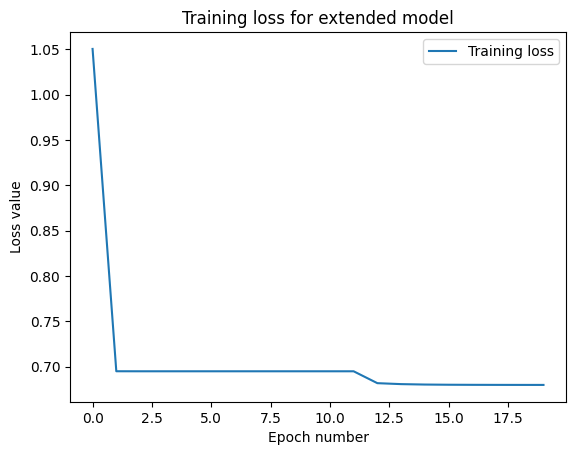

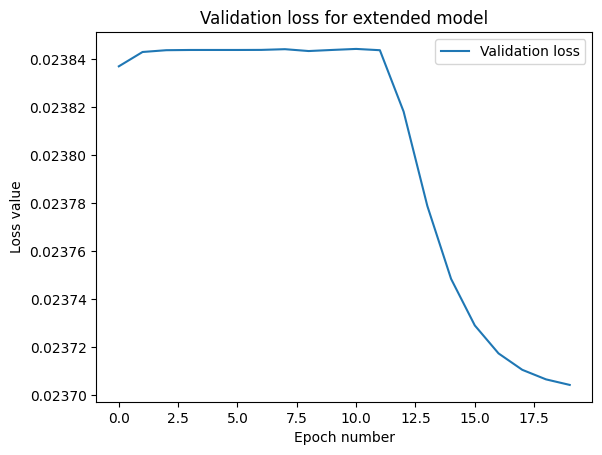

In [41]:
# plot_loss_results("results/2022.11.26.12.28/losses_.csv", which="validation", save="figures/...pdf")
# plot_loss_results(
#     "results/2022.11.25.19.31/losses_.csv",
#     which="training",
#     save="figures/basline_train_200k.pdf",
# )
# plot_loss_results(
#     "results/2022.11.25.19.31/losses_.csv",
#     which="validation",
#     save="figures/basline_valid_200k.pdf",
# )
plot_loss_results(
    "results/2022.11.26.12.28/losses_.csv",
    which="training",
    save="figures/extended_train_100k.pdf",
)
plot_loss_results(
    "results/2022.11.26.12.28/losses_.csv",
    which="validation",
    save="figures/extended_valid_100k.pdf",
)

### Inference

Inference pipeline
* Once a model is fully trained, the weights (model state) is stored to disk.
* This is again loaded in this section and we do as follows:
* for each unique (encoded) customer id:
  * for each (batch of encoded) article ids:
    * make prediction, and store value
  * find top $k$ article IDs - i.e. those with highest value
* compute MAP for all customers..

In [14]:
from collections import defaultdict


@torch.inference_mode()
def inference_alternative(model_path, test_data, k: int = 12) -> Tuple[dict, object]:
    """Make dictionary on form {customer: [art_1, ..., art_k]} for k highest predicted articles,
    for each customer and article in the *validation set*"""

    def _update_out_dict(all_preds: defaultdict):
        """Helper to add predictions to out_dict"""
        for customer_dict in all_preds:
            k_i = min(k, len(all_preds[customer_dict]))
            keys_i = np.array(list(all_preds[customer_dict].keys()))
            values_i = list(all_preds[customer_dict].values())
            top_ind = np.argpartition(values_i, -k_i)[-k_i:]
            out_dict[customer_dict] = [keys_i[top_ind].tolist()]

    # Initialize model and dataset
    num_customer, num_articles = test_data.df_id.nunique().values[:2]
    all_preds = defaultdict(dict)
    # Best preds now just finds the label-encoded stuff since we already have LF on those
    device = "cpu"
    model = HM_model(num_customer, num_articles, embedding_size=500).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    # Compute predictions
    data = test_data.get_data_from_subset(test_data.val).to_numpy()
    valid_customers, valid_articles = np.unique(data[:, 0]), np.unique(
        data[:, 1]
    )  # TODO valid cust should np.unique(data[:, 0])
    valid_customers, valid_articles = torch.IntTensor(valid_customers).to(
        device
    ), torch.IntTensor(valid_articles).to(device)
    from math import ceil

    valid_articles = np.array_split(
        valid_articles, ceil(valid_articles.shape[0] / test_data.batch_size)
    )
    out_dict = dict()
    print("Computing predictions for customers ...")
    customer_count = 0
    for customer in tqdm(valid_customers):
        customer_count += 1
        for article in valid_articles:
            customer_exp = customer.expand(article.shape[0])
            pred = model(customer_exp, article).view(-1)
            for i, pred_i in enumerate(pred):
                all_preds[customer.item()][article[i]] = pred_i
        if customer_count % 100 == 0:
            # print("Sending batch to out dict...")
            _update_out_dict(all_preds)
            # Free memory and re-initiate defaultdict
            del all_preds
            all_preds = defaultdict(dict)

    # Call this once more for the last n<100 customers
    _update_out_dict(all_preds)
    return out_dict


@torch.inference_mode()
def compute_map(
    best_preds: dict,
    test_data: Data_HM,
    k: int = 12,
    use_all_data_as_ground_truth: bool = False,
    verbose: bool = False,
):
    vprint = lambda *args: print(*args) if verbose else None
    if use_all_data_as_ground_truth:
        vprint("Returning best predicted values back to true IDs ...")
        decoded_preds = dict()
        for k, v in best_preds.items():
            unenc_k = test_data.le_cust.inverse_transform([k])[0]
            unenc_v = test_data.le_art.inverse_transform(v[0])
            decoded_preds[unenc_k] = [unenc_v]
        best_preds = decoded_preds  # Overwrites best_preds

        # Ground truth from entire database:
        vprint("Reading ground truth ...")
        ground_truth = pd.read_csv(
            "dataset/transactions_train.csv",
            dtype={"article_id": str},
            usecols=["customer_id", "article_id"],
        )
        ground_truth = ground_truth[
            ground_truth["customer_id"].isin(list(decoded_preds.keys()))
        ]
        ground_truth = (
            ground_truth.groupby("customer_id").agg({"article_id": list}).reset_index()
        )
    else:
        vprint("Loading only data in validation set")
        ground_truth = (  # This only checks the true values of the validation set
            test_data.df_id[test_data.df_id["label"] == 1]
            .groupby("customer_id")
            .agg({"article_id": list})
            .reset_index()
        )

    preds = pd.DataFrame.from_dict(best_preds, orient="index").reset_index()
    preds.columns = ["customer_id", "est_article_id"]
    vprint(
        "Value counts before removing article duplicates\n",
        ground_truth["article_id"].apply(len).value_counts().to_dict(),
    )
    # Remove duplicates
    ground_truth["article_id"] = ground_truth["article_id"].apply(
        lambda c: list(set(c))
    )
    vprint(
        "Value counts after removing article duplicates\n",
        ground_truth["article_id"].apply(len).value_counts().to_dict(),
    )

    merged = ground_truth.merge(preds)
    from utils.metrics import prec, rel

    average_precision = merged.apply(
        lambda x: sum(
            [
                prec(i, x.est_article_id, x.article_id)
                * rel(i, x.est_article_id, x.article_id)
                for i in range(1, k + 1)
            ]
        )
        / min(k, len(x.est_article_id)),
        axis=1,
    )
    map_score = average_precision.mean()
    return average_precision  # map_score


def wrapper_old():
    @torch.inference_mode()
    def inference(user_id, model, test_data, k: int = 12):
        """Based on a specific user id and test data, compute the articles with best score"""
        preds = []
        labels = []
        articles = []
        device = "cuda" if torch.cuda.is_available() else "cpu"
        for item in test_data.get_DataLoader(trainDL=False):
            item = tuple(t.to(device) for t in item)
            row, label = item
            pred = model(
                torch.IntTensor([user_id]).to(device).expand(row[:, 1].shape[0]),
                row[:, 1],
            ).view(-1)
            preds.extend(pred.cpu().detach().numpy())
            labels.extend(label.cpu().detach().numpy())
            articles.extend(row[:, 1].cpu().detach().numpy())
        preds = np.array(preds)
        labels = np.array(labels)
        topk_ind = np.argpartition(np.array(preds), k)[
            :k
        ]  # k best predictions for user
        topk_articles_enc = np.array(articles)[topk_ind]
        # Transform articles back to original shape
        topk_articles = test_data.le_art.inverse_transform(topk_articles_enc)
        return topk_articles

    @torch.inference_mode()
    def make_submission(model_path, test_data, k: int = 12):
        # Assume test_data is HM_Data object
        best_preds = {}
        num_customer, num_articles = test_data.df_id.nunique().values[:2]
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HM_model(num_customer, num_articles, embedding_size=500).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()  # Superfluous but idc
        for user_id in tqdm(test_data.df_id["customer_id"].unique()):
            user = test_data.le_cust.inverse_transform([user_id])
            # print(user)
            best_preds[user[0]] = [inference(user_id, model, test_data, k)]
        import pickle

        # with open("tmp.obj", "wb") as f:
        #     pickle.dump(best_preds, f)

        # print(best_preds)
        preds = pd.DataFrame.from_dict(best_preds, orient="index")
        preds.reset_index(inplace=True)
        preds.columns = ["customer_id", "est_article_id"]

        ground_truth = (
            test_data.df_id.groupby("customer_id")
            .agg({"article_id": list})
            .reset_index()
        )
        # Remove duplicates and transform to true IDs
        ground_truth["article_id"] = ground_truth["article_id"].apply(
            lambda c: test_data.le_art.inverse_transform(list(set(c)))
        )
        ground_truth["customer_id"] = [
            test_data.le_cust.inverse_transform([cust])[0]
            for cust in ground_truth["customer_id"]
        ]
        all = ground_truth.merge(preds)
        from utils.metrics import prec, rel

        average_precision = all.apply(
            lambda x: sum(
                [
                    prec(i, x.est_article_id, x.article_id)
                    * rel(i, x.est_article_id, x.article_id)
                    for i in range(1, k + 1)
                ]
            )
            / min(k, len(x.est_article_id)),
            axis=1,
        )
        map_score = average_precision.mean()
        return average_precision


# This is the dataset from 200k samples
data_test = read_dataset_obj("object_storage/dataset-2022.11.26.12.04.pckl")
best_preds = inference_alternative("models/2022.11.26.12.28.pth", data_test)
save_dataset_obj(best_preds, "object_storage/predictions_200k.pckl")

check_alt_inference = compute_map(
    best_preds, data_test, use_all_data_as_ground_truth=True, verbose=True
)

Computing predictions for customers ...


 76%|███████▋  | 42446/55574 [7:04:51<1:22:37,  2.65it/s] 

In [49]:
# best_preds
res = compute_map(best_preds, data_test)
np.mean(res)

0.00014042874054137264

In [16]:
def split_test_set_file():
    import numpy as np, pandas as pd, torch
    full_set = pd.read_csv("dataset/transactions_train.csv", dtype={"article_id": str})
    num_train = int(len(full_set)*0.7)
    num_test = len(full_set) - num_train
    test_idx = np.random.randint(0, len(full_set),size=num_test)
    full_set.iloc[test_idx].to_csv("dataset/tr_test.csv")
    full_set.drop(test_idx).to_csv("dataset/tr_train.csv")    